In [46]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import xrd
import helpers as h
from model_common import XRDRegressor, NormalizedXRDDataset, denorm_params, get_device
from importlib import reload

reload(xrd)
reload(h)

print("✅ Imports successful. Parameters to predict: {PARAM_NAMES}")

✅ Imports successful. Parameters to predict: {PARAM_NAMES}


In [47]:
# Paths
EXPERIMENT_FILE = "experiments/experiment.txt"
MODEL_CHECKPOINT = "checkpoints/dataset_10000_dl100_unweighted_full_augmented_finetuned.pt"
# MODEL_CHECKPOINT = "checkpoints/dataset_200000_dl100_unweighted_full_augmented.pt"

TRUNCATE_POINT = 52
MAX_LENGTH = 701
CONVERT_TO_MODAL = True

# Device
device = get_device()
print(f"Using device: {device}")

✓ Using MPS (Apple Silicon)
Using device: mps


In [48]:
def load_experimental_data(file_path):
    intensities = []
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            
            # Split by arrow if present
            if '→' in line:
                _, value = line.split('→')
            else:
                value = line
            
            # Replace comma with dot for European format
            value = value.replace(',', '.')
            
            try:
                intensities.append(float(value))
            except ValueError:
                print(f"Warning: Could not parse line: {line}")
                continue
    
    return np.array(intensities)


# Load data
exp_data = load_experimental_data(EXPERIMENT_FILE)
print(f"✅ Loaded {len(exp_data)} data points from {EXPERIMENT_FILE}")

✅ Loaded 360 data points from experiments/experiment.txt


In [49]:
simulated_curve, simulated_profile = xrd.compute_curve_and_profile(
    array=[0.008094, 0.000943, 5200e-8, 3500e-8, 0.00255, 3000e-8, -50e-8],
    dl=100e-8
)

/var/folders/jk/xsnyxvks5ts_232t26nlcr400000gn/T/ipykernel_67303/1461807731.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.semilogy(simulated_curve.Y_R_vseZ, 'b-', linewidth=1.5, label='Simulated data', color='orange')


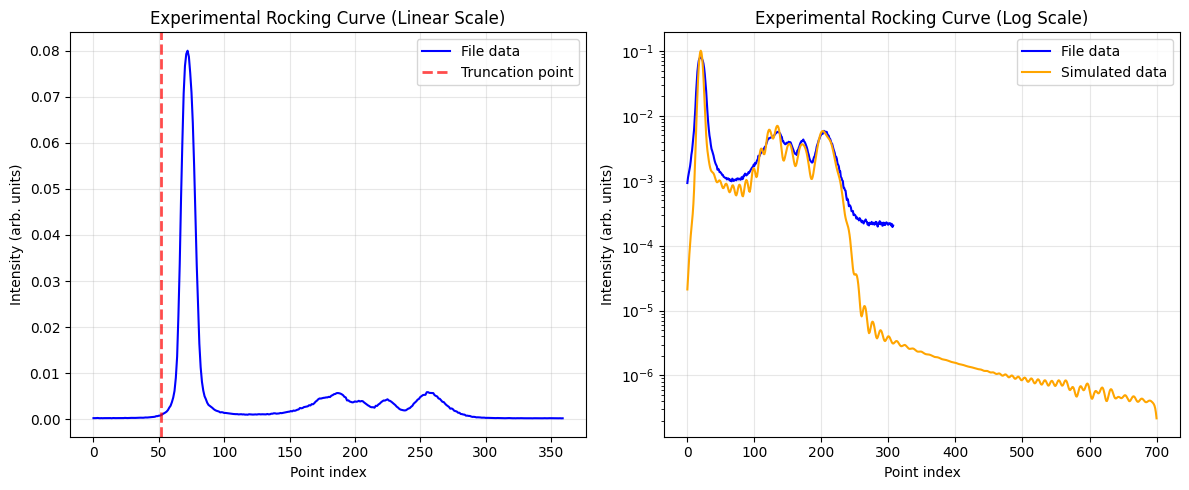

Peak position: index 72
Peak intensity: 8.0000e-02
Truncation point (start_ML): 50
Points used for ML: 310 (will be interpolated to 650)


In [50]:
plt.figure(figsize=(12, 5))

# Linear scale
plt.subplot(1, 2, 1)
plt.plot(exp_data, 'b-', linewidth=1.5, label='File data')
# plt.plot(r_curve.Y_R_vseZ, 'b-', linewidth=1.5, label='Full data', color='orange')
plt.axvline(x=TRUNCATE_POINT, color='r', linestyle='--', linewidth=2, alpha=0.7, label='Truncation point')
plt.xlabel('Point index')
plt.ylabel('Intensity (arb. units)')
plt.title('Experimental Rocking Curve (Linear Scale)')
plt.grid(True, alpha=0.3)
plt.legend()

# Log scale
plt.subplot(1, 2, 2)
plt.semilogy(exp_data[TRUNCATE_POINT:], 'b-', linewidth=1.5, label='File data')
plt.semilogy(simulated_curve.Y_R_vseZ, 'b-', linewidth=1.5, label='Simulated data', color='orange')
plt.xlabel('Point index')
plt.ylabel('Intensity (arb. units)')
plt.title('Experimental Rocking Curve (Log Scale)')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

peak_idx = np.argmax(exp_data)
print(f"Peak position: index {peak_idx}")
print(f"Peak intensity: {exp_data.max():.4e}")
print(f"Truncation point (start_ML): 50")
print(f"Points used for ML: {len(exp_data) - 50} (will be interpolated to 650)")

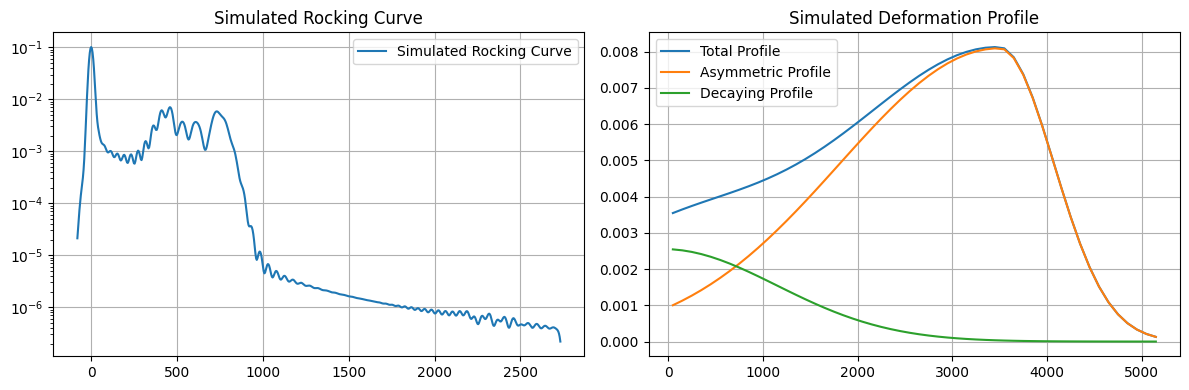

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4)) # 12 width, 4 height

axes[0].set_title("Simulated Rocking Curve")
axes[0].plot(simulated_curve.X_DeltaTeta, simulated_curve.Y_R_vseZ, label="Simulated Rocking Curve")
axes[0].set_yscale("log")
axes[0].grid(True)
axes[0].legend()

axes[1].set_title("Simulated Deformation Profile")
axes[1].plot(simulated_profile.X, simulated_profile.total_Y, label="Total Profile")
axes[1].plot(simulated_profile.X, simulated_profile.asymmetric_Y, label="Asymmetric Profile")
axes[1].plot(simulated_profile.X, simulated_profile.decaying_Y, label="Decaying Profile")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

In [52]:
def preprocess_for_model(
    data: np.ndarray,
    truncate_point: int = 50,
    max_length: int = 650,
    torch_dtype: torch.dtype = torch.float32
) -> torch.Tensor:
    n = len(data)
    print(f"Total data points: {n}")
    if n <= truncate_point:
        raise ValueError(f"Data too short! Has {n} points, need at least {truncate_point+1}")

    # Use float64 in NumPy to avoid precision loss during slicing/padding/printing
    tail = np.asarray(data[truncate_point:], dtype=np.float64)
    print(f"After skipping first {truncate_point} points: {len(tail)} points remaining")

    if len(tail) == max_length:
        processed = tail
        print(f"✅ Exact match: {max_length} points")
    elif len(tail) > max_length:
        processed = tail[:max_length]
        print(f"Truncated from {len(tail)} to {max_length} points")
    else:
        # Remain unchanged (model will handle variable length)
        processed = tail

        # pad_right = max_length - len(tail)
        # processed = np.pad(tail, (0, pad_right), mode='constant', constant_values=0.00011077211922084)
        # print(f"Padded on right with {pad_right} zeros → {processed.shape}")

    print("First 10 of processed data (scientific, 8 sig figs):")
    print(np.array2string(processed[:10], formatter={'float_kind': lambda x: f"{x:.8e}"}))

    t = torch.from_numpy(processed).to(dtype=torch_dtype)
    return t

# Preprocess experimental data
experiment_Y = preprocess_for_model(exp_data, truncate_point=TRUNCATE_POINT, max_length=MAX_LENGTH)
experiment_Y_original = experiment_Y.clone()
x_length = experiment_Y.size()[0]

if CONVERT_TO_MODAL:
    experiment_Y_copy = experiment_Y.numpy()
    experiment_last = 220
    simulated_first = 190
    experiment_Y_new = np.concat(
        [simulated_curve.Y_R_vseZ[:20], 
        experiment_Y_copy[20:experiment_last], 
        simulated_curve.Y_R_vseZ[simulated_first:x_length-(experiment_last-simulated_first)]
    ])
    experiment_Y = torch.from_numpy(experiment_Y_new).to(dtype=torch.float32)

print(f"\n✅ Preprocessed data shape: {experiment_Y.shape}")
print(f"Data range after normalization: {experiment_Y.min():.4f} to {experiment_Y.max():.4f}")

Total data points: 360
After skipping first 52 points: 308 points remaining
First 10 of processed data (scientific, 8 sig figs):
[9.25000000e-04 1.13000000e-03 1.29000000e-03 1.46000000e-03
 1.67000000e-03 2.00000000e-03 2.52000000e-03 2.93000000e-03
 3.71000000e-03 4.69000000e-03]

✅ Preprocessed data shape: torch.Size([308])
Data range after normalization: 0.0000 to 0.0949


In [53]:
print(experiment_Y[:10].numpy())
print(experiment_Y[-10:].numpy())
print(experiment_Y.size())

[2.11779661e-05 3.29081959e-05 5.01474315e-05 7.40644755e-05
 1.04778956e-04 1.41453231e-04 1.83811018e-04 2.35466694e-04
 3.09912197e-04 4.42301593e-04]
[7.5306584e-06 6.0015400e-06 4.9380556e-06 4.4838607e-06 4.6107912e-06
 5.1477800e-06 5.8436367e-06 6.4426677e-06 6.7516212e-06 6.6816810e-06]
torch.Size([308])


## 4. Load Trained Model

In [54]:
# Load model checkpoint
if not Path(MODEL_CHECKPOINT).exists():
    raise FileNotFoundError(f"Model checkpoint not found: {MODEL_CHECKPOINT}")

checkpoint = torch.load(MODEL_CHECKPOINT, map_location=device)
print(f"Checkpoint contains: {list(checkpoint.keys())}")

# Initialize model
model = XRDRegressor().to(device)
model.load_state_dict(checkpoint['model'])
model.eval()

print(f"✅ Loaded checkpoint from {MODEL_CHECKPOINT}")

Checkpoint contains: ['model', 'L', 'epoch', 'val_loss']
✅ Loaded checkpoint from checkpoints/dataset_10000_dl100_unweighted_full_augmented_finetuned.pt


## 5. Make Predictions

In [55]:
print(f"Input data length for model: {x_length} points")
model_X = torch.tensor(np.linspace(0, x_length - 1, x_length)).unsqueeze(0)
model_Y = experiment_Y.unsqueeze(0)

ds = NormalizedXRDDataset(model_X, torch.tensor(simulated_curve.Y_R_vseZ, dtype=torch.float32).unsqueeze(0), train=False)
# ds = NormalizedXRDDataset(model_X, model_Y, train=False)
dl = torch.utils.data.DataLoader(ds, batch_size=256)

preds = []
with torch.no_grad():
    for y, _ in dl:
        p = model(y.to(device))
        preds.append(p.to(device))
P = torch.cat(preds, dim=0)
Theta_hat = denorm_params(P)

Input data length for model: 308 points


In [56]:
P

tensor([[2.8238e-01, 2.1668e-05, 6.4274e-01, 6.4268e-01, 4.6845e-02, 6.1172e-01,
         9.9843e-01]], device='mps:0')

In [57]:
preds

[tensor([[2.8238e-01, 2.1668e-05, 6.4274e-01, 6.4268e-01, 4.6845e-02, 6.1172e-01,
          9.9843e-01]], device='mps:0')]

## 6. Visualize Predicted Deformation Profile

Using the predicted parameters, compute the theoretical curve and deformation profile.

In [58]:
pred_values = Theta_hat[0]

In [59]:
pred_values

tensor([ 9.4715e-03,  5.0065e-04,  4.6778e-05,  3.2634e-05,  2.4054e-03,
         3.2527e-05, -1.0202e-07], device='mps:0')

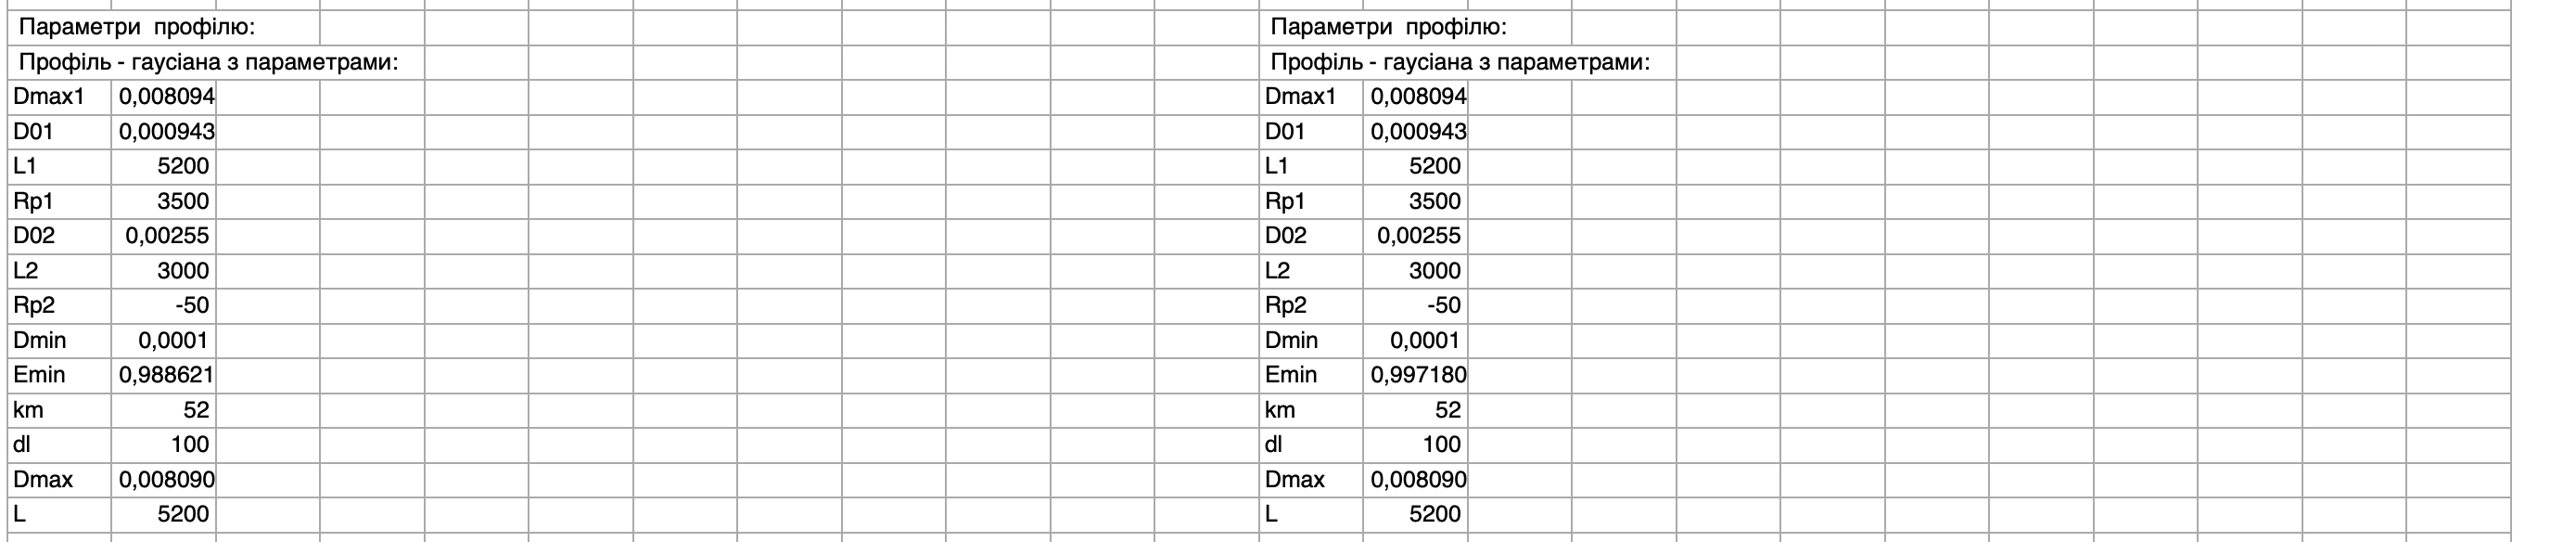

In [60]:
model_Y.numpy()[0][:10]

array([2.11779661e-05, 3.29081959e-05, 5.01474315e-05, 7.40644755e-05,
       1.04778956e-04, 1.41453231e-04, 1.83811018e-04, 2.35466694e-04,
       3.09912197e-04, 4.42301593e-04], dtype=float32)

In [61]:
simulated_curve.ML_Y[:10]

array([0.00094432, 0.00087537, 0.00081147, 0.0007736 , 0.0007727 ,
       0.00080491, 0.00085284, 0.00089247, 0.00090291, 0.00087502])

In [62]:
predicted_curve, predicted_profile = xrd.compute_curve_and_profile(
    array=pred_values.tolist(),
    dl=100e-8
)

In [63]:
x = torch.linspace(0, x_length - 1, x_length)

In [64]:
predicted_curve.Y_R_vseZ[:20]

array([5.99337082e-05, 7.32065503e-05, 8.43889798e-05, 9.59490983e-05,
       1.13481138e-04, 1.44662481e-04, 1.97572083e-04, 2.79741706e-04,
       4.00652776e-04, 5.83071237e-04, 8.94983106e-04, 1.52242203e-03,
       2.90280042e-03, 5.89813563e-03, 1.18778194e-02, 2.24446012e-02,
       3.85647632e-02, 5.92785436e-02, 8.08494090e-02, 9.74626496e-02])

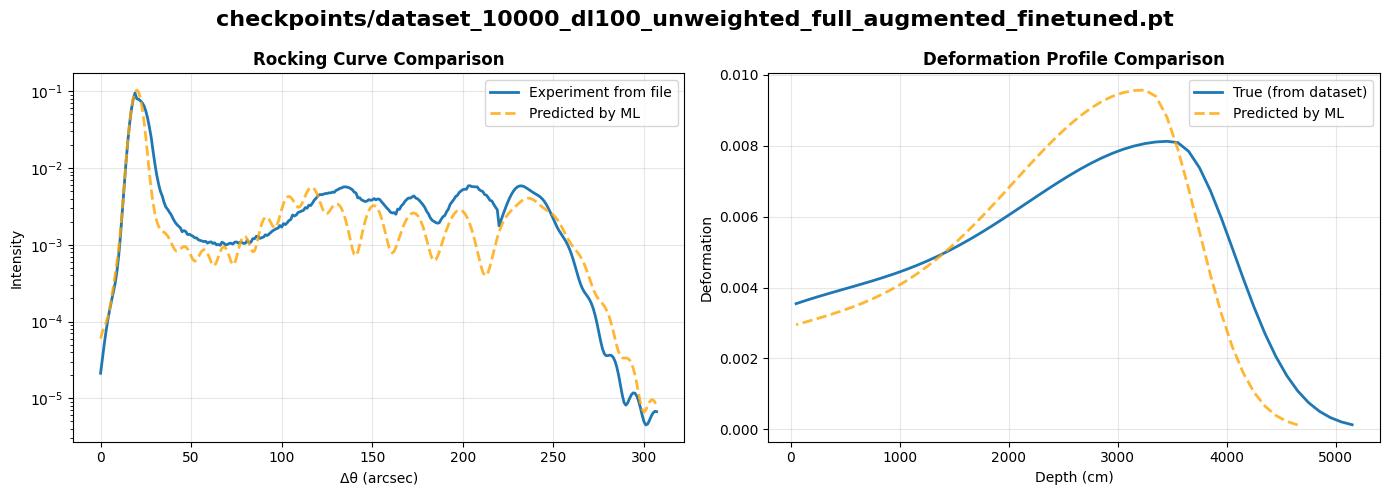

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

fig.suptitle(MODEL_CHECKPOINT, fontsize=16, fontweight='bold')

# Rocking Curve
axes[0].set_title("Rocking Curve Comparison", fontsize=12, fontweight='bold')
axes[0].plot(x, experiment_Y.numpy(), label="Experiment from file", color='C0', linestyle='-', linewidth=2)

# Predicted curve
axes[0].plot(x, predicted_curve.Y_R_vseZ[:x_length], 
             label="Predicted by ML", color='orange', linestyle='--', linewidth=2, alpha=0.8)

# Simulated curve
# axes[0].plot(x, simulated_curve.Y_R_vseZ[:x_length], 
#              label="SIMULATED CURVE", color='green', linestyle=':', linewidth=2, alpha=0.8)
# axes[0].plot(x, experiment_Y_new, 
#              label="SIMULATED CURVE", color='red', linestyle=':', linewidth=2, alpha=0.8)

axes[0].set_xlabel("Δθ (arcsec)")
axes[0].set_ylabel("Intensity")
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Deformation Profile
axes[1].set_title("Deformation Profile Comparison", fontsize=12, fontweight='bold')
axes[1].plot(simulated_profile.X, simulated_profile.total_Y, 
             label="True (from dataset)", color='C0', linestyle='-', linewidth=2)
axes[1].plot(predicted_profile.X, predicted_profile.total_Y, 
             label="Predicted by ML", color='orange', linestyle='--', linewidth=2, alpha=0.8)
axes[1].set_xlabel("Depth (cm)")
axes[1].set_ylabel("Deformation")
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

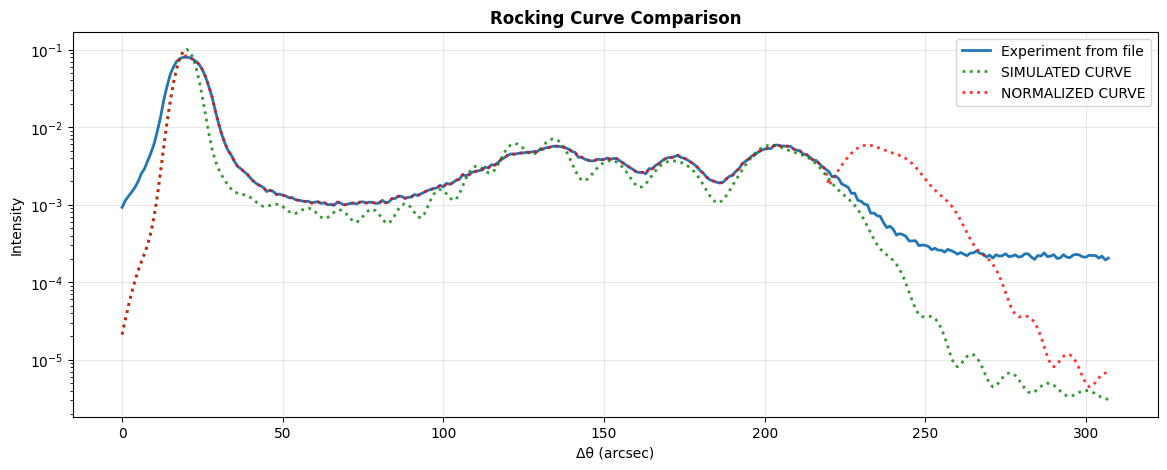

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
# Rocking Curve
ax.set_title("Rocking Curve Comparison", fontsize=12, fontweight='bold')
ax.plot(x, experiment_Y_original.numpy(), label="Experiment from file", color='C0', linestyle='-', linewidth=2)

# Predicted curve
# ax.plot(x, predicted_curve.Y_R_vseZ[:x_length], 
#         label="Predicted by ML", color='orange', linestyle='--', linewidth=2, alpha=0.8)

# Simulated curve
ax.plot(x, simulated_curve.Y_R_vseZ[:x_length], 
        label="SIMULATED CURVE", color='green', linestyle=':', linewidth=2, alpha=0.8)
ax.plot(x, experiment_Y.numpy(), 
             label="NORMALIZED CURVE", color='red', linestyle=':', linewidth=2, alpha=0.8)

ax.set_xlabel("Δθ (arcsec)")
ax.set_ylabel("Intensity")
ax.set_yscale('log')
ax.grid(True, alpha=0.3)
ax.legend()

In [67]:
# # DDparam[0] = Dmax1
# # DDparam[1] = D01
# # DDparam[2] = L1
# # DDparam[3] = Rp1
# # DDparam[4] = D02
# # DDparam[5] = L2
# # DDparam[6] = Rp2

# true_pred_pairs = [
#     [[0.008094, 0.000943, 5200e-8, 3500e-8, 0.00255, 3000e-8, -50e-8], pred_values.tolist()],
#     [[0.008094, 0.000943, 5200e-8, 3500e-8, 0.00255, 3000e-8, -50e-8], pred_values.tolist()],
# ]

# print(true_pred_pairs)

# def plot_profils(ax, profile, color, linestyle, pred=False):
#     ax.plot(profile.X, profile.total_Y, label='DD (Total)', color=color, linestyle=linestyle)
#     ax.plot(profile.X, profile.asymmetric_Y, label=None, linestyle=':', color=color)
#     ax.plot(profile.X, profile.decaying_Y, label=None, linestyle=':', color=color)
#     ax.set_xlabel('z (Å)')
#     ax.set_ylabel('Deformation profile')

# fig, axes = plt.subplots(len(true_pred_pairs), 2, figsize=(12, 6))
# plt.subplots_adjust(hspace=0.6)  # add vertical space between rows

# for i, (true_params, pred_params) in enumerate(true_pred_pairs):
#     print(f"True params: {true_params}, Pred params: {pred_params}")
#     # add true_params to plot
#     curve, profile_true = xrd.compute_curve_and_profile(
#         array=true_params,
#         dl=100e-8
#     )
    
#     axes[i, 0].plot(curve.X_DeltaTeta, curve.Y_R_vseZ, label="True")
#     axes[i, 0].grid(True)
#     axes[i, 0].set_ylim(0, 0.02)

#     # plot_profils(axes[i, 1], profile_true, 'C0', '-')

#     curve, profile_pred = xrd.compute_curve_and_profile(
#         array=pred_params,
#         dl=100e-8
#     )

#     plot_profils(axes[i, 1], profile_pred, 'C1', '--')
#     axes[i, 0].plot(curve.X_DeltaTeta, curve.Y_R_vseZ, label="Predicted", linestyle='dashed')
#     axes[i, 1].set_title(f"True: {h.fparam(arr=true_params)}\nPred: {h.fparam(arr=pred_params)}")
#     axes[i, 1].grid(True)
#     axes[i, 1].set_ylim(0, 0.03)
#     axes[i, 1].legend()
#     axes[i, 0].legend()


# plt.tight_layout()
# plt.show()